# Preliminaries and Enter Your Ticker Here!

In [1]:
import numpy as np
import pandas as pd

symbol = 'FB'

## Leading Indicators Prices

In [5]:
from iexfinance.stocks import Stock

indicators = ['SPY', 'QQQ']
batch = Stock( indicators )
batch.get_price()

{'QQQ': 171.03, 'SPY': 273.1}

In [3]:
quotes = batch.get_quote()
DisplayDict = {
    'Last': 'latestPrice',
    '% Change': 'changePercent'
}

for sym in indicators:
    print(f'---{sym}---')
    for display in DisplayDict:
        print( f'{display}: {quotes[sym][DisplayDict[display]]}')

---SPY---
Last: 269.92
% Change: -0.00052
---QQQ---
Last: 167.45
% Change: 0


## Stock Description

In [28]:
from iexfinance.stocks import Stock

myStock = Stock(symbol)

In [29]:
info = myStock.get_company()
lKeyInfo = ['companyName', 'description', 'exchange']

print('--- Company Description ---')
for key in lKeyInfo:
    print(f'{key}: {info[key]}')

--- Company Description ---
companyName: Facebook Inc.
description: Facebook Inc is the world's largest online social network. Its products are Facebook, Instagram, Messenger, WhatsApp, and Oculus. Its products enable people to connect and share through mobile devices and personal computers.
exchange: Nasdaq Global Select


In [30]:
stats = myStock.get_key_stats()
lKeyStats = [ 'beta', 'dividendRate', 'exDividendDate',
            'priceToBook', 'priceToSales', 'sharesOutstanding',
            'week52high', 'week52low']

print('--- Key Stats ---')
for key in lKeyStats:
    print( f'{key}: {stats[key]}')

--- Key Stats ---
beta: 0.913787
dividendRate: 0
exDividendDate: 0
priceToBook: 5.62
priceToSales: 8.604919
sharesOutstanding: 2853989800
week52high: 218.62
week52low: 123.02


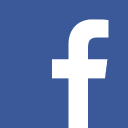

In [31]:
logo = myStock.get_logo()

from IPython.display import Image
Image(logo['url'])

## Market Book
**Need to be tested during market hours**

In [18]:
myStock = Stock(symbol)
book = myStock.get_book()

def PrintBidAsk(quote_dict):
    if not quote_dict['bids'] or not quote_dict['asks']:
        data = quote_dict['quote']
        for side in ['Bid', 'Ask']:
            price = data[f'iex{side}Price']
            size = data[f'iex{side}Size']
            
            print(f'Last {side}: {price} x {size}')
        
        print(f'Updated at: {data["iexLastUpdated"]}')
    
    else:   # Show Live Bid Ask
        for side in ['bids', 'asks']:
            price = quote_dict[side][0]['price']
            size = quote_dict[side][0]['size']
            
            print(f'{side}: {price} x {size}')

In [19]:
PrintBidAsk(book)

Last Bid: 0 x 0
Last Ask: 0 x 0
Updated at: 1549313999952


In [17]:
book

{'asks': [{'price': 166.43, 'size': 200, 'timestamp': 1549292661171},
  {'price': 168, 'size': 121, 'timestamp': 1549291229030},
  {'price': 170.48, 'size': 100, 'timestamp': 1549290943007},
  {'price': 172.09, 'size': 100, 'timestamp': 1549290601954},
  {'price': 175, 'size': 100, 'timestamp': 1549290602657},
  {'price': 178, 'size': 300, 'timestamp': 1549290602660},
  {'price': 180, 'size': 200, 'timestamp': 1549290602651},
  {'price': 200, 'size': 250, 'timestamp': 1549290601922}],
 'bids': [{'price': 166.35, 'size': 100, 'timestamp': 1549292662974},
  {'price': 166.31, 'size': 100, 'timestamp': 1549292650016},
  {'price': 120, 'size': 100, 'timestamp': 1549290606899},
  {'price': 98.44, 'size': 112, 'timestamp': 1549290600062}],
 'quote': {'avgTotalVolume': 28528671,
  'calculationPrice': 'tops',
  'change': 0.72,
  'changePercent': 0.00434,
  'close': 165.71,
  'closeTime': 1549054800529,
  'companyName': 'Facebook Inc.',
  'delayedPrice': 166.57,
  'delayedPriceTime': 15492917606

## Intraday Time Series Tick Data for Consecutive Dates
* for pandas ploting [this](http://jonathansoma.com/lede/algorithms-2017/classes/fuzziness-matplotlib/how-pandas-uses-matplotlib-plus-figures-axes-and-subplots/) was helpful
* for DateTime objects manipulation, [this](http://strftime.org/) is a good reference

In [78]:
from datetime import datetime, timedelta, date
from iexfinance.stocks import get_historical_intraday
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

tdate = datetime(2019,2,4)
tdate_neg1 = tdate - timedelta( days = 3)       # NEED TO ADD IN MARKET DATE ADJUST FUNCTION

tdata = get_historical_intraday(symbol, tdate, output_format = 'pandas')
tdata_neg1 = get_historical_intraday(symbol, tdate_neg1, output_format = 'pandas')

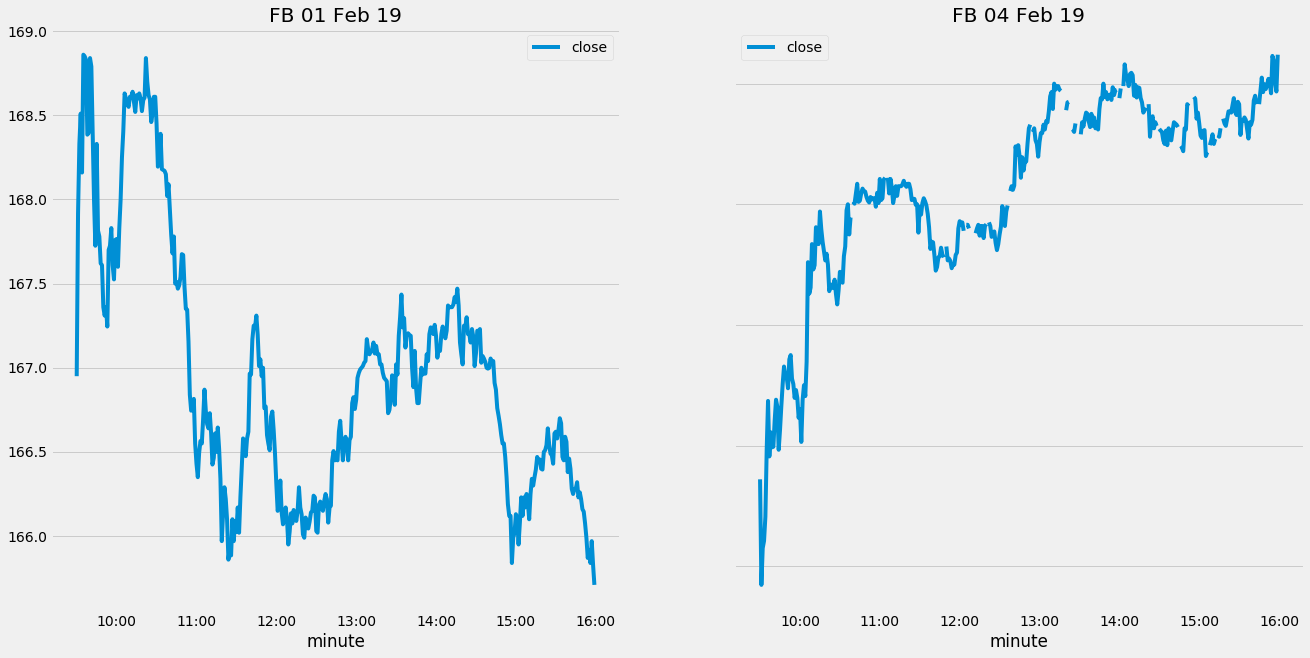

In [113]:
tdata.index = pd.DatetimeIndex( tdata.index )
tdata_neg1.index = pd.DatetimeIndex( tdata_neg1.index)

plot_dict = {
    tdate_neg1 : tdata_neg1,
    tdate : tdata
}

#tdata.plot(y = 'close', title = f'{symbol} {tdate.strftime("%d %b %y")}')

for i, idate in enumerate(plot_dict):
    ax = plt.subplot(1,2, i+1) 
    plot_dict[idate].plot( y = 'close', 
                          title = f'{symbol} {idate.strftime("%d %b %y")}', 
                         ax = ax, figsize = (20,10),
                         sharey = True)

### Let's join the two Dates' intraday prices into one DF

In [109]:
def DatePlusTime( DateObj, TimeObj):
    '''
    return a DateTime object
    
    requires datetime, time, and timedelta
    '''
    tdelta = datetime.combine( date.min, TimeObj) - datetime.min
    return DateObj  + tdelta

# Turning Time of the DF into DateTime
tdata['DT'] = tdata.index
tdata['DT'] = tdata['DT'].apply(lambda x : DatePlusTime(tdate ,x.time()))

tdata_neg1['DT'] = tdata_neg1.index
tdata_neg1['DT'] = tdata_neg1['DT'].apply(lambda x : DatePlusTime(tdate_neg1 ,x.time()))

# Concat the two day
l_col = ['DT', 'close']
data = pd.concat([tdata[l_col], tdata_neg1[l_col]])
data.index = data['DT']

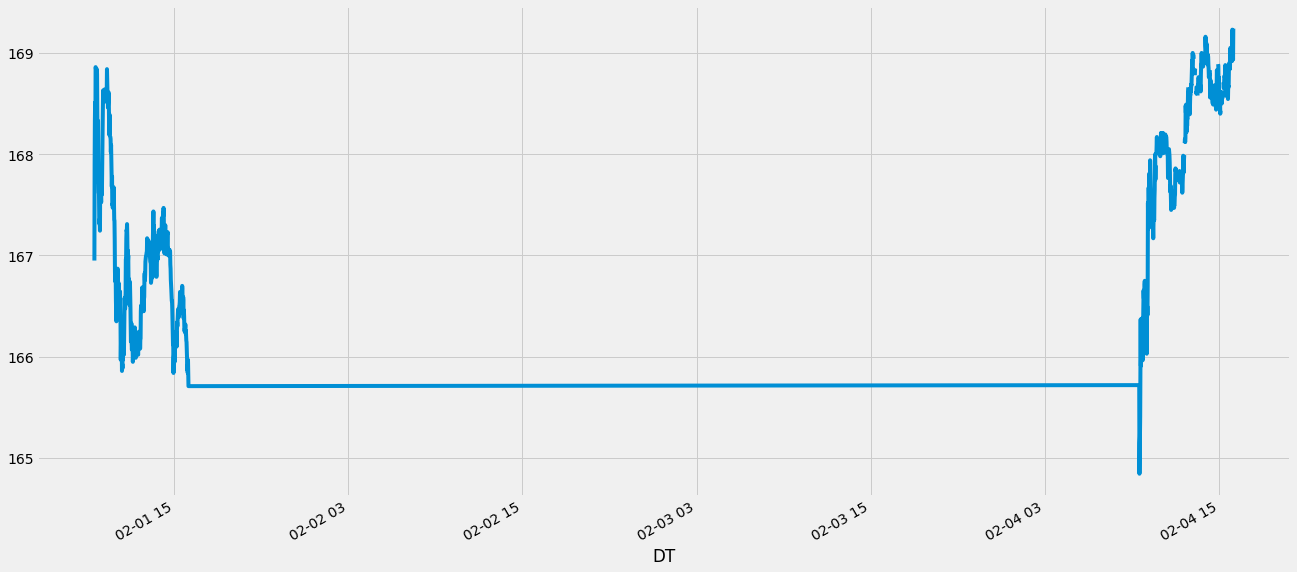

In [112]:
data['close'].plot(figsize=(20,10))

# Market Time and Date Adjust
Let's install some preliminary packages:
* `pandas_market_calendars` [git](https://github.com/rsheftel/pandas_market_calendars) [doc](https://pandas-market-calendars.readthedocs.io/en/latest/usage.html)

In [9]:
from datetime import datetime, time
import pandas_market_calendars as mcal

## UTC Time Convert (?)
[Here's](https://www.timeanddate.com/time/aboututc.html) a definition of UTC Time

Function `TimeConvert_UTC` inspired by this [stackoverflow post](https://stackoverflow.com/questions/48416511/how-to-convert-utc-to-est-with-python-and-take-care-of-daylight-saving-automatic?noredirect=1&lq=1)

`pytz` documentation is available [here](http://pytz.sourceforge.net/)

In [19]:
def TimeConvert_UTC( UTCTime, OutZone):
    from datetime import datetime
    import pytz
    
    #from_zone = pytz.utc
    to_zone = pytz.timezone(OutZone)
    
    return UTCTime.astimezone(to_zone)

let's get a time to test

In [18]:
myStock = Stock(symbol)
book = myStock.get_book()
utc_timestamp = book['quote']['closeTime']
utc_datetime = datetime.fromtimestamp(utc_timestamp / 1e3)

print(f'Our UTC Time is {utc_datetime.strftime("%d %b %y %H:%M %Z")}')
# %Z is silent if object is naive

Our UTC Time is 06 Feb 19 05:00 


In [20]:
TimeConvert_UTC(utc_datetime, 'US/Eastern')

datetime.datetime(2019, 2, 5, 16, 0, 0, 708000, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>)

## Is Market Open

In [ ]:
# Let's load our Market
mkt_hours = mcal.get_calendar('NYSE')

# Let's get a date to test


## Market Date Adjust